In [1]:
import os
import random

import chainer
import data
from chainer.dataset import convert
from sklearn.datasets import load_digits, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
#from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
plt.style.use('ggplot')
from PIL import Image

from defCVAE import CVAE
%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
'''
# Load the MNIST dataset
mnist = data.load_mnist_data()
#split train : test = 8 :2 
X_train, X_test, L_train, L_test = train_test_split(mnist["data"], mnist["target"], test_size=0.2)
#convert dict => np array
X_train = np.array(X_train, dtype='float32') / 255
X_test = np.array(X_test, dtype='float32') / 255
L_train = np.array(L_train, dtype='int32')
L_test = np.array(L_test, dtype='int32')
#print(X_train.shape)
#print(L_train.shape)

train_count = len(X_train)
l_train_half = np.concatenate([L_train[0:(train_count/2)], np.ones(train_count-(train_count/2))*-1]).astype('int32')

#  list : [image label]  
Xy_train = [(x, y) for x, y in zip(X_train, l_train_half)]
Xy_test = [(x, -1) for x, y in zip(X_test, L_test)]
'''

'\n# Load the MNIST dataset\nmnist = data.load_mnist_data()\n#split train : test = 8 :2 \nX_train, X_test, L_train, L_test = train_test_split(mnist["data"], mnist["target"], test_size=0.2)\n#convert dict => np array\nX_train = np.array(X_train, dtype=\'float32\') / 255\nX_test = np.array(X_test, dtype=\'float32\') / 255\nL_train = np.array(L_train, dtype=\'int32\')\nL_test = np.array(L_test, dtype=\'int32\')\n#print(X_train.shape)\n#print(L_train.shape)\n\ntrain_count = len(X_train)\nl_train_half = np.concatenate([L_train[0:(train_count/2)], np.ones(train_count-(train_count/2))*-1]).astype(\'int32\')\n\n#  list : [image label]  \nXy_train = [(x, y) for x, y in zip(X_train, l_train_half)]\nXy_test = [(x, -1) for x, y in zip(X_test, L_test)]\n'

# 画像の切り出し・訓練データ作成とか

image size:(140, 56)
(784,)


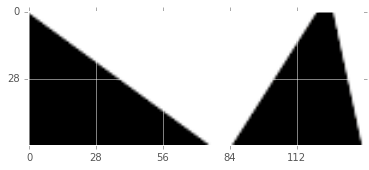

In [3]:
#Show iamge
IMG = Image.open("test_image.png")
plt.xticks(np.arange(0,140,28))
plt.yticks(np.arange(0,56,28))
plt.imshow(np.asarray((IMG)))
print("image size:"+str(IMG.size))
img = Image.open("test_image.png").convert("L")

def cropImage(center_x, center_y, height, width):
    left = center_x - width/2
    upper = center_y - height/2
    right = center_x + width/2
    lower = center_y + height/2
    c_img = img.crop((left, upper, right, lower))
    carr = np.asarray(c_img)
    carr = carr.flatten()
    #print(c_img)
    carr = np.asarray(carr).astype(np.float32)
    return np.array(carr, dtype=np.float32)/255

def random_crop(DATA_NUM):
    image_list = np.empty(28*28,dtype=np.float32)
    #print(image_list.size)
    for n in range(DATA_NUM):
        # choice 14 <= x <= 126 && 14 <= y <= 42
        randx = np.random.rand()*112 + 14
        randy = np.random.rand()*28 + 14
        c_image = cropImage(int(randx), int(randy), 28, 28)
        #print(c_image.shape)
        image_list = np.vstack((image_list, c_image))
    image_list = np.delete(image_list, 0,axis=0)
    return image_list

ans = random_crop(3)
print(ans[0].shape)
s_img = ans[0]
#plt.imshow(np.asarray((s_img.reshape(28,28))))

X_train = random_crop(800)
X_test = random_crop(200)
L_train = np.full(800,0)
L_test = np.full(200,0)
#print(L_train.shape)

train_count = len(X_train)
l_train_half = np.concatenate([L_train[0:(train_count/2)], np.ones(train_count-(train_count/2))*-1]).astype('int32')

#  list : [image label]  
Xy_train = [(x, y) for x, y in zip(X_train, l_train_half)]
Xy_test = [(x, -1) for x, y in zip(X_test, L_test)]

In [4]:
def train(input_size, hidden_size, z_size, label_size, minibatch_size, epoch_num, X_train, output):
    model = CVAE(input_size, z_size, hidden_size, label_size)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)
    
    train_iter = chainer.iterators.SerialIterator(X_train, minibatch_size)
    for epoch in range(0, epoch_num):
        sum_loss = 0
        sum_rec_loss = 0
        batch = train_iter.next()
        x_array, t_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        t = chainer.Variable(t_array)
        optimizer.update(model.get_loss_func(C=0.1, k=5), x, t)
        
        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)
        
    chainer.serializers.save_npz(output, model)
    print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / train_count, sum_rec_loss / train_count))

def test_plot(model, X_test, L_test):
    colors_dict = {}
    cm = plt.get_cmap('jet')
    for dic in range(0,10):
        colors_dict[dic] = cm(1.*dic/10)

    #markers = ["*", "s", "v", "^", "+", "o", "P", "D", "p", "d"]
        train_iter = chainer.iterators.SerialIterator(X_test, len(X_test), repeat=False, shuffle=False)
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        batch = train_iter.next()
        x_array, t_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        t = chainer.Variable(t_array)
        x_mu, log_var = model.encode(x, t)
        print('mu size:{}'.format(x_mu.shape))
        print('logvar size:{}'.format(log_var.shape))
    data_dict = {}
    for x, y in zip(x_mu.data, L_test):
        if y in data_dict:
            data_dict[y].append(x)
        else:
            data_dict[y] = [x]
    #plt.axes(axisbg='#FFFAFF')
    for y in range(0, 10):
        data = data_dict[y]
        xs  = [row[0] for row in data]
        ys = [row[1] for row in data]
        plt.scatter(xs, ys, c=colors_dict[y], label=y, alpha=0.6)
    plt.title("CVAE")
    plt.grid()
    plt.legend()
    
    plt.show()
    
def test_decode(model, x, label, output):
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_v = chainer.Variable(x)
        label_v = chainer.Variable(label)
        y_v = model(x_v, label_v)
        print('出力')
        pixels = (y_v.data * 256).reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.axis("off")
        plt.show()
        #plt.imsave(output, pixels, cmap='gray')

# 訓練

In [5]:
#main
EPOCH_NUM = 1000
INPUT_SIZE = 784
HIDDEN_SIZE = 128
MINIBATCH_SIZE = 100
LABEL_SIZE = 10
Z_SIZE = 20

scores = {}
MODEL_PATH_CVAE = './CVAE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)

train(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    z_size=Z_SIZE,
    label_size=LABEL_SIZE,
    minibatch_size=MINIBATCH_SIZE,
    epoch_num=EPOCH_NUM,
    X_train=Xy_train,
    output=MODEL_PATH_CVAE
)

train mean loss=3.0614862442, mean reconstruction loss=2.56192398071


# 訓練した重みを使って文字を生成

入力


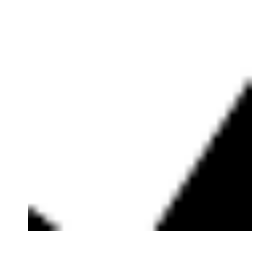

出力


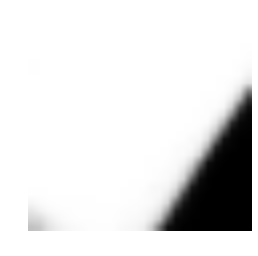

In [6]:
INPUT_SIZE = 784
HIDDEN_SIZE = 128
Z_SIZE = 20
MINIBATCH_SIZE = 100
LABEL_SIZE = 10
MODEL_PATH = './CVAE_1000_20.model'

model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)
chainer.serializers.load_npz(MODEL_PATH, model)

print('入力')
pixels = (X_test[[5]] * 256).reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.axis("off")
plt.show()

test_decode(model, X_test[[5]], np.array([-1], dtype='int32'), MODEL_PATH )

# 画像が潜在空間のどこに分布しているのか表示

In [7]:
'''
INPUT_SIZE = 784
HIDDEN_SIZE = 128
Z_SIZE = 2
MINIBATCH_SIZE = 100
LABEL_SIZE = 10
MODEL_PATH = './CVAE_1000_2.model'
model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)
chainer.serializers.load_npz(MODEL_PATH, model)
test_plot(model, Xy_test[0:200], L_test[0:200])
'''

"\nINPUT_SIZE = 784\nHIDDEN_SIZE = 128\nZ_SIZE = 2\nMINIBATCH_SIZE = 100\nLABEL_SIZE = 10\nMODEL_PATH = './CVAE_1000_2.model'\nmodel = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)\nchainer.serializers.load_npz(MODEL_PATH, model)\ntest_plot(model, Xy_test[0:200], L_test[0:200])\n"